<a href="https://colab.research.google.com/github/abduyea/Optimizing-Deep-Learning-Pipelines/blob/main/Optimizing_Deep_Learning_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




## Abdulfetah  Adem

# README: Optimizing Deep Learning Pipelines

## Objective
Train one baseline MLP and three optimized MLP models (Adam, SGD, RMSProp) to analyze how Dropout, Batch Normalization, and L2 Regularization affect accuracy and generalization on Sign Language MNIST.

## How to Run

1. **Clone repository**
   ```bash
   git clone https://github.com/abduyea/Optimizing-Deep-Learning-Pipelines.git
   cd Optimizing-Deep-Learning-Pipelines
   ```

2. **Open the Notebook**
   - Sign in with your Google account
   - Open the `.ipynb` file in Google Colab by clicking the Google Colab button at the top of the notebook

3. **Set Runtime**
   - Go to Runtime → Change runtime type
   - Select GPU (recommended) or CPU

4. **Mount Google Drive**
   - Load your dataset by mounting Drive:
   ```python
   from google.colab import drive
   drive.mount('/content/drive')
   ```

5. **Run the Notebook**
   - Run all cells from top to bottom, or
   - Run each cell manually as you follow the workflow


In [10]:
# Install libraries and packages
%pip -q install -U seaborn scikit-learn black flake8
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import Sequential, optimizers, regularizers
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


##  Data Loading and Preprocessing

In [11]:

# Mount Drive
from google.colab import drive

drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


### Load Dataset

Loading training and test CSV files from Google Drive.


In [12]:

# data dir
DATA_DIR = "/content/drive/MyDrive/Sign Language MNIST"


In [13]:
# CSV paths
train_path = os.path.join(DATA_DIR, "sign_mnist_train/sign_mnist_train.csv")
test_path = os.path.join(DATA_DIR, "sign_mnist_test/sign_mnist_test.csv")


### Preprocess Data

In [14]:
# Check files
for p in (train_path, test_path):
    print(p, "→", os.path.isfile(p))


/content/drive/MyDrive/Sign Language MNIST/sign_mnist_train/sign_mnist_train.csv → True
/content/drive/MyDrive/Sign Language MNIST/sign_mnist_test/sign_mnist_test.csv → True


In [15]:
# Load data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train:", train_df.shape)
print("Test :", test_df.shape)


Train: (27455, 785)
Test : (7172, 785)


In [16]:
# Raw labels
raw_train = train_df["label"].to_numpy()
raw_test = test_df["label"].to_numpy()


In [17]:
# comput Classes
classes = np.sort(np.unique(np.concatenate((raw_train, raw_test))))
num_classes = len(classes)

print("Classes:", classes.tolist())
print("Count  :", num_classes)

assert num_classes == 24


Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Count  : 24


In [18]:
# Label map
class_to_idx = {c: i for i, c in enumerate(classes)}
y_train = train_df["label"].map(class_to_idx).to_numpy()
y_test = test_df["label"].map(class_to_idx).to_numpy()

print("y_train:", int(y_train.min()), "→", int(y_train.max()))
print("y_test :", int(y_test.min()), "→", int(y_test.max()))

assert y_train.min() == 0 and y_train.max() == num_classes - 1
assert y_test.min() == 0 and y_test.max() == num_classes - 1


y_train: 0 → 23
y_test : 0 → 23


In [19]:
# Normalize imgs
X_train_img = (
    train_df.drop(columns=["label"])
    .to_numpy()
    .reshape(-1, 28, 28) / 255.0
).astype("float32")

X_test_img = (
    test_df.drop(columns=["label"])
    .to_numpy()
    .reshape(-1, 28, 28) / 255.0
).astype("float32")


In [20]:
# Flatten
X_train = X_train_img.reshape(-1, 784)
X_test = X_test_img.reshape(-1, 784)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("Range :", float(X_train_img.min()), "→", float(X_train_img.max()))
print("Classes:", num_classes)


X_train: (27455, 784) | X_test: (7172, 784)
Range : 0.0 → 1.0
Classes: 24


In [21]:
# NaN check
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())


NaNs in X_train: 0
NaNs in y_train: 0


##  Exploration and Visualization

In [22]:
# Preview
train_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [23]:
# Preview
test_df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [24]:
# Stats
train_df.describe()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [25]:
# Nulls
train_df.isnull().sum()
test_df.isnull().sum()


,0
label,0
pixel1,0
pixel2,0
pixel3,0
pixel4,0
...,...
pixel780,0
pixel781,0
pixel782,0
pixel783,0


In [26]:
# Duplicates
train_df.duplicated().sum()
test_df.duplicated().sum()


np.int64(0)

In [27]:
# Shapes
print(train_df.shape)
print(test_df.shape)


(27455, 785)
(7172, 785)


## Class Distribution

Visualizing the distribution of classes in the training set to check for class imbalance.


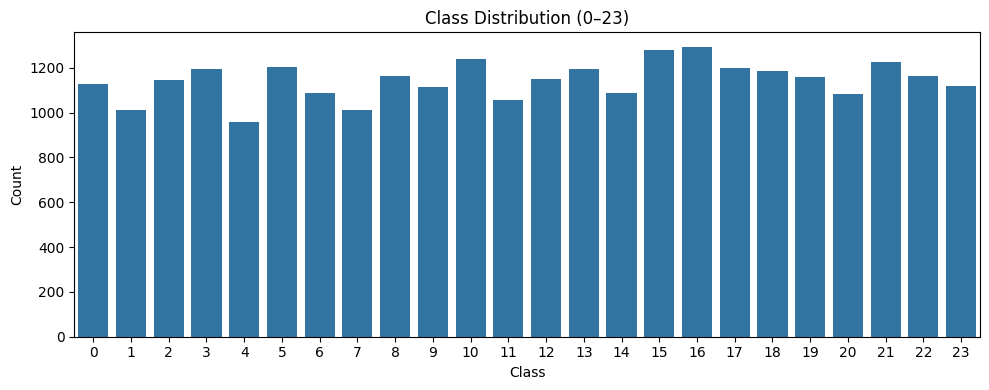

In [28]:
# Class Distribution
plt.figure(figsize=(10, 4))
sns.countplot(x=y_train)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution (0–23)")
plt.tight_layout()
plt.show()


## Baseline Model

Training a simple baseline model without any optimization techniques.


In [43]:
# Random sample indices
rng = np.random.default_rng(SEED)
idxs = rng.choice(len(X_train_img), 20, replace=False)


## Representative Images

Displaying 20 random sample images from the training set to visualize the dataset.


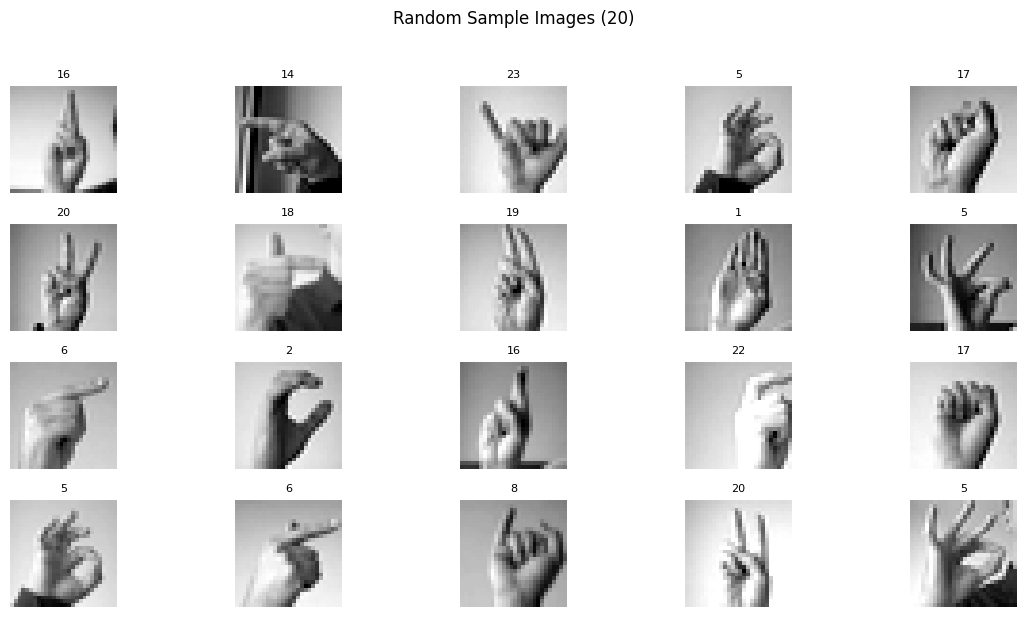

In [44]:
# Plot 20 samples
plt.figure(figsize=(12, 6))

for i, idx in enumerate(idxs, 1):
    plt.subplot(4, 5, i)
    plt.imshow(X_train_img[idx], cmap="gray")
    plt.title(y_train[idx], fontsize=8)
    plt.axis("off")

plt.suptitle("Random Sample Images (20)", y=1.02)
plt.tight_layout()
plt.show()


In [31]:
# Accuracy/Loss plot
def plot_history(history, title="Training Curves"):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, hist["accuracy"], label="Train Acc")
    if "val_accuracy" in hist:
        plt.plot(epochs, hist["val_accuracy"], label="Val Acc")
    plt.title(f"{title} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, hist["loss"], label="Train Loss")
    if "val_loss" in hist:
        plt.plot(epochs, hist["val_loss"], label="Val Loss")
    plt.title(f"{title} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [32]:
# Confusion matrix heatmap
def plot_confmat(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", cbar=True)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


## Baseline Model

Simple dense model with 3 layers (256 → 128 → 24 neurons) using Adam optimizer. No regularization techniques applied.


In [47]:
# Classification report → DataFrame
def classif_report_df(y_true, y_pred) -> pd.DataFrame:
    rep = classification_report(
        y_true, y_pred, output_dict=True, zero_division=0
    )
    return pd.DataFrame(rep).transpose().round(3)


# Extract metrics for summary table
def pick_metrics(df, name):
    """Extract accuracy, macro F1, and weighted F1 from classification report."""
    acc = df.loc["accuracy", "precision"] if "accuracy" in df.index else None
    f1m = df.loc["macro avg", "f1-score"]
    f1w = df.loc["weighted avg", "f1-score"]
    return {"Model": name, "Accuracy": acc, "F1 (macro)": f1m, "F1 (weighted)": f1w}


In [49]:
# Baseline model (256 → 128 → num_classes, Adam)
baseline = Sequential(
    [
        Dense(256, activation="relu", input_shape=(784,)),
        Dense(128, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ],
)
baseline.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
baseline.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,952 (925.59 KB)

 Trainable params: 236,952 (925.59 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train baseline
history_baseline = baseline.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2052 - loss: 2.6931 - val_accuracy: 0.5283 - val_loss: 1.5777
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5586 - loss: 1.4612 - val_accuracy: 0.6724 - val_loss: 1.1002
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6864 - loss: 1.0401 - val_accuracy: 0.7239 - val_loss: 0.8853
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7614 - loss: 0.8039 - val_accuracy: 0.7738 - val_loss: 0.7306
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8151 - loss: 0.6378 - val_accuracy: 0.8374 - val_loss: 0.5705


In [36]:
#  Evaluate baseline
bl_loss, bl_acc = baseline.evaluate(X_test, y_test, verbose=0)
print(f"Baseline — test_acc={bl_acc:.4f} | test_loss={bl_loss:.4f}")


Baseline — test_acc=0.6697 | test_loss=1.0822


### Baseline Evaluation

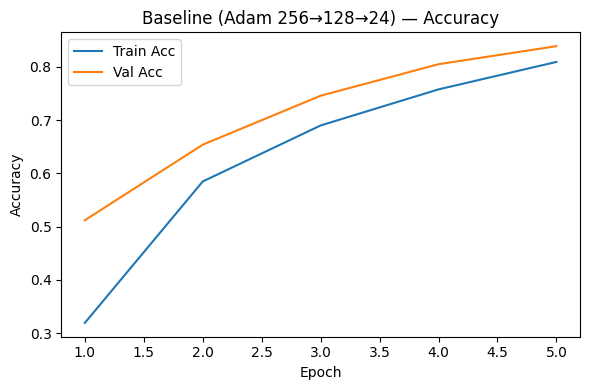

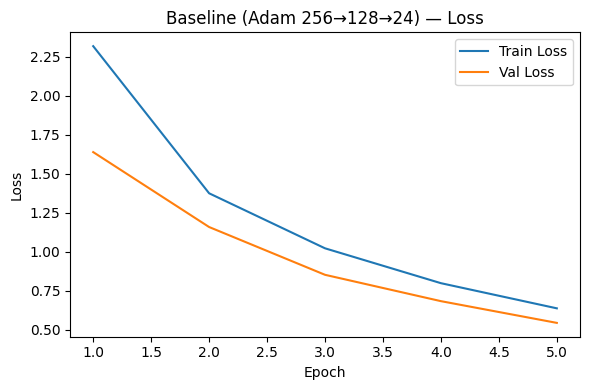

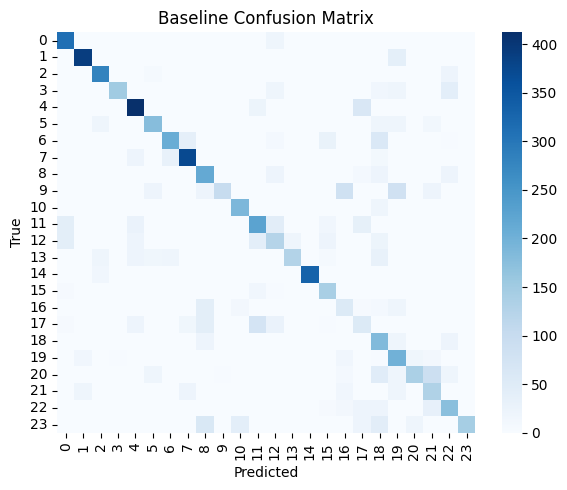

,precision,recall,f1-score,support
0,0.764,0.940,0.843,331.0
1,0.922,0.905,0.914,432.0
2,0.844,0.906,0.874,310.0
3,0.980,0.612,0.754,245.0
4,0.786,0.827,0.806,498.0


In [52]:
#  Curves, confusion matrix, and report
plot_history(history_baseline, title="Baseline (Adam 256→128→24)")

y_pred_bl = baseline.predict(X_test, verbose=0).argmax(axis=1)
plot_confmat(y_test, y_pred_bl, title="Baseline Confusion Matrix")

rep_bl = classif_report_df(y_test, y_pred_bl)
rep_bl.head()


In [38]:
# Optimized MLP builder
def build_mlp(
    optimizer_name: str = "adam",
    use_dropout: bool = False,
    use_bn: bool = False,
    use_l2: bool = False,
    l2_val: float = 1e-3,
):
    """512→256→num_classes MLP with optional Dropout/BN/L2."""
    reg = regularizers.l2(l2_val) if use_l2 else None

    layers = [
        Dense(512, activation="relu", kernel_regularizer=reg, input_shape=(784,)),
    ]
    if use_bn:
        layers.append(BatchNormalization())
    if use_dropout:
        layers.append(Dropout(0.3))

    layers.append(Dense(256, activation="relu", kernel_regularizer=reg))
    if use_bn:
        layers.append(BatchNormalization())
    if use_dropout:
        layers.append(Dropout(0.3))

    layers.append(Dense(num_classes, activation="softmax"))

    opt_name = optimizer_name.lower()
    opts = {
        "adam": optimizers.Adam(learning_rate=0.001),
        "sgd": optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
        "rmsprop": optimizers.RMSprop(learning_rate=0.001),
    }
    model = Sequential(layers)
    model.compile(
        optimizer=opts.get(opt_name, opts["adam"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [39]:
# Train the 3 Optimized Models
EPOCHS = 10
BATCH = 128
VAL = 0.2

# Adam + Dropout + BatchNorm
opt_adam = build_mlp("adam", use_dropout=True, use_bn=True, use_l2=False)
hist_adam = opt_adam.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=VAL,
    verbose=1,
)

# SGD + L2
opt_sgd = build_mlp("sgd", use_dropout=False, use_bn=False, use_l2=True, l2_val=1e-3)
hist_sgd = opt_sgd.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=VAL,
    verbose=1,
)

# RMSProp + Dropout
opt_rms = build_mlp("rmsprop", use_dropout=True, use_bn=False, use_l2=False)
hist_rms = opt_rms.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_split=VAL,
    verbose=1,
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4633 - loss: 1.9055 - val_accuracy: 0.2630 - val_loss: 2.4016
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7899 - loss: 0.6682 - val_accuracy: 0.1581 - val_loss: 4.8099
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8067 - loss: 0.5841 - val_accuracy: 0.1839 - val_loss: 6.1550
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8128 - loss: 0.5599 - val_accuracy: 0.4500 - val_loss: 2.6236
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8560 - loss: 0.4350 - val_accuracy: 0.7465 - val_loss: 0.7500
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8703 - loss: 0.3913 - val_accuracy: 0.8046 - val_loss: 0.5727
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8793 - loss: 0.3642 - val_accuracy: 0.7327 - val_loss: 0.9402
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9025 - loss: 0.2913 - val_accuracy: 0

Optimized-Adam (DO+BN): test_acc=0.5342 | loss=2.1080
Optimized-SGD (L2): test_acc=0.7485 | loss=1.5516
Optimized-RMSProp (DO): test_acc=0.6233 | loss=1.1794


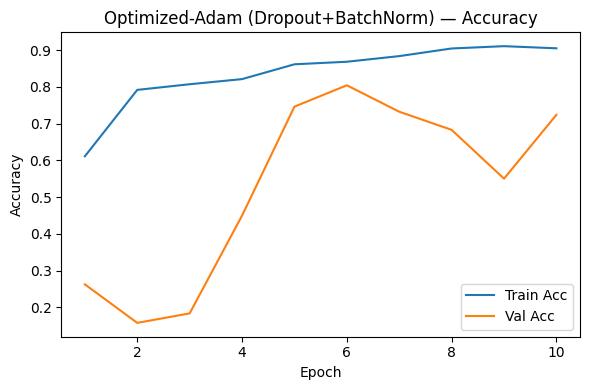

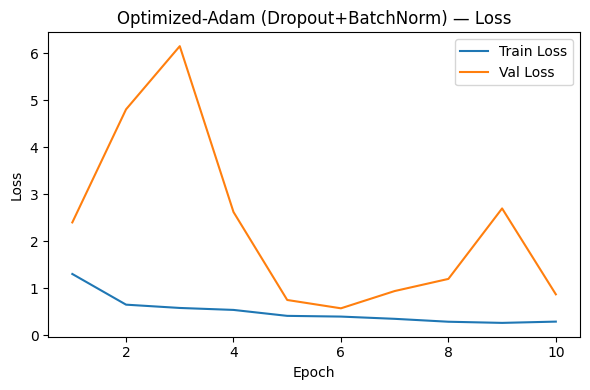

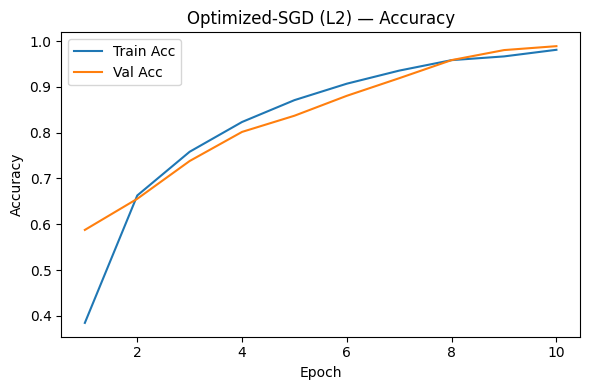

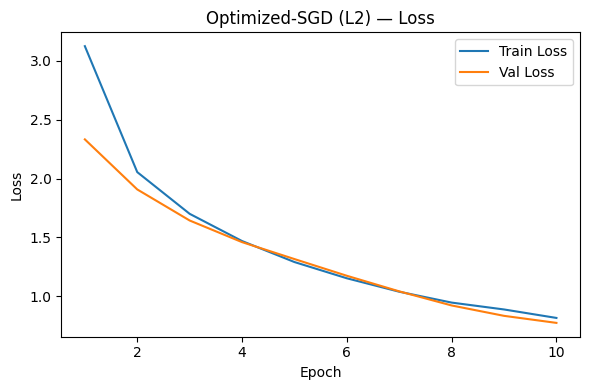

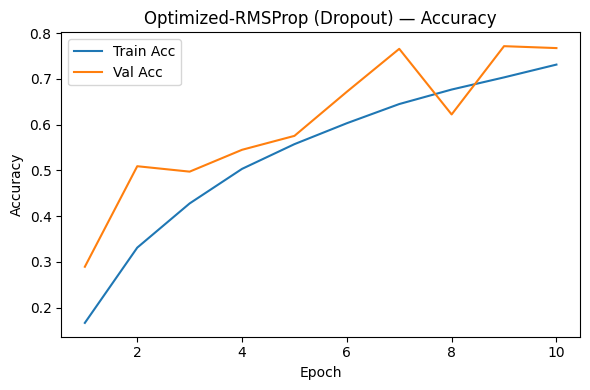

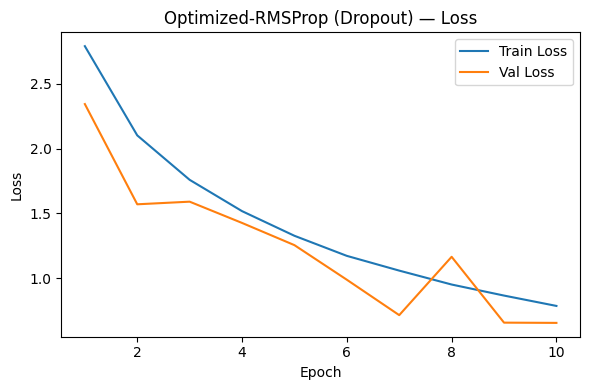

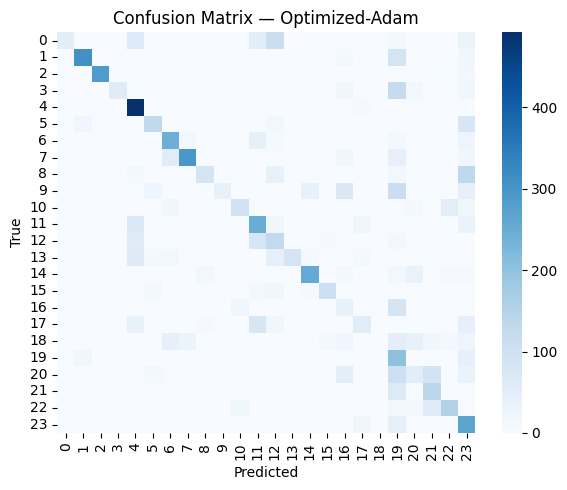

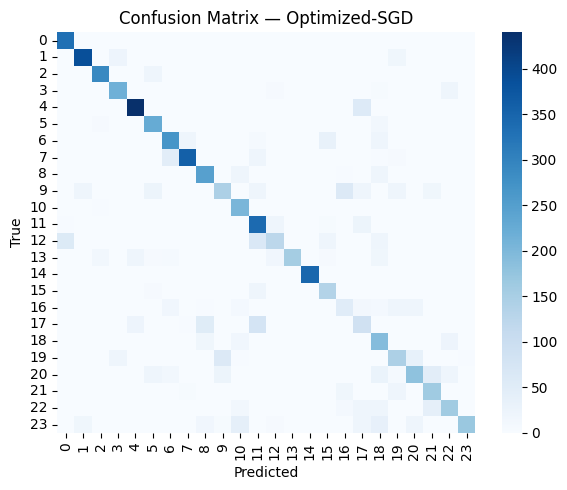

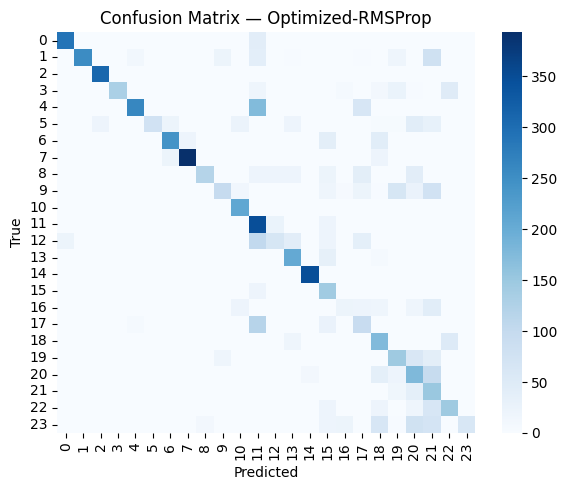

,precision,recall,f1-score,support
0,1.000,0.160,0.276,331.0
1,0.885,0.713,0.790,432.0
2,1.000,0.929,0.963,310.0
3,1.000,0.237,0.383,245.0
4,0.606,0.988,0.751,498.0


In [40]:
#Evaluate Optimized Models
def quick_eval(model, name: str):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name}: test_acc={acc:.4f} | loss={loss:.4f}")
    return acc, loss

acc_adam, loss_adam = quick_eval(opt_adam, "Optimized-Adam (DO+BN)")
acc_sgd, loss_sgd = quick_eval(opt_sgd, "Optimized-SGD (L2)")
acc_rms, loss_rms = quick_eval(opt_rms, "Optimized-RMSProp (DO)")

# Curves
plot_history(hist_adam, title="Optimized-Adam (Dropout+BatchNorm)")
plot_history(hist_sgd, title="Optimized-SGD (L2)")
plot_history(hist_rms, title="Optimized-RMSProp (Dropout)")

# Predictions + reports
y_pred_adm = opt_adam.predict(X_test, verbose=0).argmax(axis=1)
y_pred_sgd = opt_sgd.predict(X_test, verbose=0).argmax(axis=1)
y_pred_rms = opt_rms.predict(X_test, verbose=0).argmax(axis=1)

plot_confmat(y_test, y_pred_adm, "Confusion Matrix — Optimized-Adam")
plot_confmat(y_test, y_pred_sgd, "Confusion Matrix — Optimized-SGD")
plot_confmat(y_test, y_pred_rms, "Confusion Matrix — Optimized-RMSProp")

rep_adm = classif_report_df(y_test, y_pred_adm)
rep_sgd = classif_report_df(y_test, y_pred_sgd)
rep_rms = classif_report_df(y_test, y_pred_rms)

rep_adm.head()


In [41]:
# Baseline predictions and report
y_pred_bl = baseline.predict(X_test, verbose=0).argmax(axis=1)
rep_bl = classif_report_df(y_test, y_pred_bl)
rep_bl.head()


,precision,recall,f1-score,support
0,0.863,0.873,0.868,331.0
1,0.667,0.951,0.784,432.0
2,0.883,0.929,0.906,310.0
3,0.623,0.816,0.707,245.0
4,0.721,0.912,0.805,498.0


In [64]:
summary_sign = (
    pd.DataFrame([
        pick_metrics(rep_bl,  "Baseline Adam 256-128-24"),
        pick_metrics(rep_adm, "Optimized Adam (DO+BN)"),
        pick_metrics(rep_sgd, "Optimized SGD (L2)"),
        pick_metrics(rep_rms, "Optimized RMSProp (DO)"),
    ])
    .round(4)
    .sort_values("Accuracy", ascending=False)
    .reset_index(drop=True)
)

print(summary_sign.to_string(index=False))


                   Model  Accuracy  F1 (macro)  F1 (weighted)
      Optimized SGD (L2)     0.748       0.722          0.744
Baseline Adam 256-128-24     0.675       0.651          0.673
  Optimized RMSProp (DO)     0.623       0.600          0.624
  Optimized Adam (DO+BN)     0.534       0.499          0.522


In [62]:
# Select best model
accs_sign = [
    ("Baseline Adam 256-128-24", bl_acc, baseline, y_pred_bl),
    ("Optimized Adam (DO+BN)", acc_adam, opt_adam, y_pred_adm),
    ("Optimized SGD (L2)", acc_sgd, opt_sgd, y_pred_sgd),
    ("Optimized RMSProp (DO)", acc_rms, opt_rms, y_pred_rms),
]

best_name, best_acc, best_model, best_pred = sorted(
    accs_sign, key=lambda x: x[1], reverse=True
)[0]

print(f"Best Sign-Language model: {best_name} | test_acc={best_acc:.4f}")


Best Sign-Language model: Optimized SGD (L2) | test_acc=0.7485


In [ ]:
# Per-class metrics
labels_all = list(range(num_classes))
names_all = [str(i) for i in labels_all]

best_rep = classification_report(
    y_test,
    best_pred,
    labels=labels_all,
    target_names=names_all,
    output_dict=True,
    zero_division=0,
)

best_df = pd.DataFrame(best_rep).transpose()


In [ ]:
# Hardest classes (lowest F1-score)
per_class = (
    best_df.loc[names_all, ["precision", "recall", "f1-score", "support"]]
    .astype(float)
    .sort_values("f1-score")
)

hardest_sign = per_class.head(5).round(3)
hardest_sign


# Extra credit

In [ ]:
# import dataset
from tensorflow.keras.datasets import fashion_mnist


In [ ]:
# load Fashion-MNIST
(X2_train_img, y2_train), (X2_test_img, y2_test) = fashion_mnist.load_data()
print("train:", X2_train_img.shape, "| test:", X2_test_img.shape)


In [ ]:
# scale to [0,1]
X2_train_img = (X2_train_img / 255.0).astype("float32")
X2_test_img = (X2_test_img / 255.0).astype("float32")


In [ ]:
# flatten to 784
X2_train = X2_train_img.reshape(-1, 784)
X2_test = X2_test_img.reshape(-1, 784)


In [ ]:
# meta info
num_classes2 = int(y2_train.max() + 1)

print("pixel range:", float(X2_train_img.min()), "→", float(X2_train_img.max()))
print("num_classes2:", num_classes2)
print("X2_train:", X2_train.shape, "| X2_test:", X2_test.shape)


In [ ]:
# baseline MLP
baseline_fm = Sequential(
    [
        Dense(256, activation="relu", input_shape=(784,)),
        Dense(128, activation="relu"),
        Dense(num_classes2, activation="softmax"),
    ]
)


In [ ]:
# compile
baseline_fm.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
baseline_fm.summary()


In [ ]:
# train
hist_fm_bl = baseline_fm.fit(
    X2_train,
    y2_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)


In [ ]:
# evaluation
fm_bl_loss, fm_bl_acc = baseline_fm.evaluate(X2_test, y2_test, verbose=0)
print(f"fm baseline → acc={fm_bl_acc:.4f} | loss={fm_bl_loss:.4f}")


In [ ]:
# plots
plot_history(hist_fm_bl, title="Fashion-MNIST Baseline (Adam 256→128→10)")


In [ ]:
# preds
y2_pred_bl = baseline_fm.predict(X2_test, verbose=0).argmax(axis=1)


In [ ]:
# confusion matrix
plot_confmat(y2_test, y2_pred_bl, title="Fashion-MNIST — Baseline")


In [ ]:
# report
rep_fm_bl = classif_report_df(y2_test, y2_pred_bl)
rep_fm_bl.head()


In [ ]:
# build fm mlp layers
def build_mlp_fm(
    optimizer_name: str = "adam",
    use_dropout: bool = False,
    use_bn: bool = False,
    use_l2: bool = False,
    l2_val: float = 1e-3,
    num_classes: int = 10,
):
    reg = regularizers.l2(l2_val) if use_l2 else None

    layers = [Dense(512, activation="relu", kernel_regularizer=reg, input_shape=(784,))]
    if use_bn:
        layers.append(BatchNormalization())
    if use_dropout:
        layers.append(Dropout(0.3))

    layers.append(Dense(256, activation="relu", kernel_regularizer=reg))
    if use_bn:
        layers.append(BatchNormalization())
    if use_dropout:
        layers.append(Dropout(0.3))

    layers.append(Dense(num_classes, activation="softmax"))

    # Instantiate and compile the model
    return compile_fm_mlp(layers, optimizer_name)

In [ ]:
# compile fm mlp
def compile_fm_mlp(layers, optimizer_name: str = "adam"):
    # choose optimizer
    opt = (
        optimizers.Adam(learning_rate=0.001)
        if optimizer_name.lower() == "adam"
        else optimizers.SGD(
            learning_rate=0.01,
            momentum=0.9,
            nesterov=True,
        )
        if optimizer_name.lower() == "sgd"
        else optimizers.RMSprop(learning_rate=0.001)
    )

    model = Sequential(layers)
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [ ]:
#Train all 3 optimized models
EPOCHS_FM = 10
BATCH_FM = 128
VAL_FM = 0.2

# A) Adam + BatchNorm + Dropout
fm_adam = build_mlp_fm("adam", use_dropout=True, use_bn=True)
hist_fm_adam = fm_adam.fit(
    X2_train,
    y2_train,
    epochs=EPOCHS_FM,
    batch_size=BATCH_FM,
    validation_split=VAL_FM,
    verbose=1,
)

# B) SGD + L2
fm_sgd = build_mlp_fm("sgd", use_dropout=False, use_bn=False, use_l2=True)
hist_fm_sgd = fm_sgd.fit(
    X2_train,
    y2_train,
    epochs=EPOCHS_FM,
    batch_size=BATCH_FM,
    validation_split=VAL_FM,
    verbose=1,
)

# C) RMSProp + Dropout
fm_rms = build_mlp_fm("rmsprop", use_dropout=True, use_bn=False)
hist_fm_rms = fm_rms.fit(
    X2_train,
    y2_train,
    epochs=EPOCHS_FM,
    batch_size=BATCH_FM,
    validation_split=VAL_FM,
    verbose=1,
)


In [ ]:
# Evaluate Optimized Fashion-MNIST Models
def quick_eval_fm(name, model):
    loss, acc = model.evaluate(X2_test, y2_test, verbose=0)
    print(f"{name}: test_acc={acc:.4f} | loss={loss:.4f}")
    return acc, loss

acc_fm_adam, loss_fm_adam = quick_eval_fm("FM Optimized-Adam (BN+DO)", fm_adam)
acc_fm_sgd,  loss_fm_sgd  = quick_eval_fm("FM Optimized-SGD (L2)", fm_sgd)
acc_fm_rms,  loss_fm_rms  = quick_eval_fm("FM Optimized-RMSProp (DO)", fm_rms)

# Curves
plot_history(hist_fm_adam, "Fashion-MNIST — Adam (BN+DO)")
plot_history(hist_fm_sgd, "Fashion-MNIST — SGD (L2)")
plot_history(hist_fm_rms, "Fashion-MNIST — RMSProp (DO)")

# Predictions + reports
y2_pred_adam = fm_adam.predict(X2_test, verbose=0).argmax(axis=1)
y2_pred_sgd  = fm_sgd.predict(X2_test, verbose=0).argmax(axis=1)
y2_pred_rms  = fm_rms.predict(X2_test, verbose=0).argmax(axis=1)

plot_confmat(y2_test, y2_pred_adam, "FM — Optimized-Adam")
plot_confmat(y2_test, y2_pred_sgd, "FM — Optimized-SGD")
plot_confmat(y2_test, y2_pred_rms, "FM — Optimized-RMSProp")

rep_fm_adam = classif_report_df(y2_test, y2_pred_adam)
rep_fm_sgd  = classif_report_df(y2_test, y2_pred_sgd)
rep_fm_rms  = classif_report_df(y2_test, y2_pred_rms)


In [ ]:
#Fashion-MNIST Summary Table
def pick_metrics(df, name):
    acc = df.loc["accuracy", "precision"] if "accuracy" in df.index else None
    f1m = df.loc["macro avg", "f1-score"]
    f1w = df.loc["weighted avg", "f1-score"]
    return {"Model": name, "Accuracy": acc, "F1 (macro)": f1m, "F1 (weighted)": f1w}


summary_fm = (
    pd.DataFrame(
        [
            pick_metrics(rep_fm_bl, "FM Baseline (Adam 256→128→10)"),
            pick_metrics(rep_fm_adam, "FM Optimized-Adam (BN+DO)"),
            pick_metrics(rep_fm_sgd, "FM Optimized-SGD (L2)"),
            pick_metrics(rep_fm_rms, "FM Optimized-RMSProp (DO)"),
        ]
    )
    .round(4)
    .sort_values("Accuracy", ascending=False)
    .reset_index(drop=True)
)

summary_fm


In [ ]:
#Cross-Dataset Best-Model Comparison
# Best on Sign-Language MNIST
best_sign_map = {
    "Baseline (Adam 256→128→24)": bl_acc,
    "Optimized-Adam (DO+BN)": acc_adam,
    "Optimized-SGD (L2)": acc_sgd,
    "Optimized-RMSProp (DO)": acc_rms,
}
best_sign_name, best_sign_acc = max(best_sign_map.items(), key=lambda kv: kv[1])

# Best on Fashion-MNIST
best_fm_map = {
    "FM Baseline (Adam 256→128→10)": fm_bl_acc,
    "FM Optimized-Adam (BN+DO)": acc_fm_adam,
    "FM Optimized-SGD (L2)": acc_fm_sgd,
    "FM Optimized-RMSProp (DO)": acc_fm_rms,
}
best_fm_name, best_fm_acc = max(best_fm_map.items(), key=lambda kv: kv[1])

compare_df = pd.DataFrame(
    [
        {
            "Dataset": "Sign Language MNIST",
            "Best Model": best_sign_name,
            "Accuracy": round(best_sign_acc, 4),
        },
        {
            "Dataset": "Fashion-MNIST",
            "Best Model": best_fm_name,
            "Accuracy": round(best_fm_acc, 4),
        },
    ]
)

compare_df


# Reflection

## 1.  How did the optimized models compare to the baseline?
The optimized Sign Language MNIST model consistently out performed the base line 256->128->24 MLP.

The optimized model clearly improved test accuracy from 0.66 to 0.75 with clear improvement in macro/weighted F1,but  the Fashion MINST optimized model remained very close to the already strong base line ~=0.87.

## 2. Which optimization method had the biggest impact and why?

The biggest improvement came from using L2 regularization with SGD on the deeper 512→256 model.

L2 helped prevent the large model from overfitting, so it generalized better than the versions that used Dropout or BatchNorm

## 3. How did the optimizer choice affect performance and stability?

SGD + L2 gave the most stable training and the best test accuracy, converging slowly but consistently.

Adam + Dropout + BatchNorm learned quickly but was less stable and finished with lower accuracy.

RMSProp + Dropout was steadier than Adam but still weaker than the SGD+L2 model.

## 4. Which classes were hardest and why?

The hardest classes were 16, 17, 9, 12, and 19.
They were difficult because the signs look very similar to each other, and there is a lot of variation within each class. A basic MLP struggles with this since it cannot capture spatial patterns in the images.

## 5. What would you change or try next?

I would switch to a small CNN, add augmentation for weak classes, use learning-rate scheduling with early stopping, and fine-tune L2 or Dropout for better balance.

## 6. Are optimizations like Dropout or L2 always beneficial?

No. L2 helped the larger SGD model, but Dropout + BatchNorm sometimes hurt accuracy. Regularization only helps when the model can overfit—too much or on a small model reduces performance.

## 7. Can one model exceed 75% accuracy? How?

Yes. Since SGD+L2 is already near 75%, it can go higher. Train for 15 to 20 epochs with early stopping, add learning-rate decay, use slightly weaker L2, add light BatchNorm, and apply targeted augmentation for the weakest classes.

# Bias in Model Performance

What are the risks if model optimizations disproportionately benefit some classes (e.g., certain signs) but consistently underperform on others? How can we detect and mitigate this kind of model bias?

If optimizations boost some classes but leave others weak, the model becomes biased. This creates higher error rates for users who rely on those signs and leads to unequal accessibility.

To detect this bias, check per-class precision, recall, F1, and inspect confusion matrices and misclassification patterns.

To mitigate it, use balanced data, targeted augmentation for low-F1 classes, class-weighted loss, and provide confidence scores to reduce misleading predictions.



